In [5]:

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import cv2
import json
import yaml

print("=" * 70)
print("ОЦЕНКА И ДЕМОНСТРАЦИЯ МОДЕЛИ (person-weapon-v2)")
print("=" * 70 + "\n")


ОЦЕНКА И ДЕМОНСТРАЦИЯ МОДЕЛИ (person-weapon-v2)



# ЧАСТЬ 1: ЗАГРУЗКА МОДЕЛИ

In [9]:
print("=" * 70)
print("ЗАГРУЗКА МОДЕЛИ")
print("=" * 70 + "\n")

from ultralytics import YOLO

BASE_DIR = Path('../data')
MODELS_DIR = Path('../models')
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODELS_DIR / 'yolov8n_best.pt'

if MODEL_PATH.exists():
    print(f"Загрузка модели: {MODEL_PATH}")
    model = YOLO(str(MODEL_PATH))
    print(f"Модель загружена успешно\n")
else:
    print(f"ОШИБКА: Модель не найдена по пути: {MODEL_PATH}")
    print("Запустите сначала: 02_model_training.ipynb")
    MODEL_PATH = None

# Загрузить конфиг
YAML_PATH = BASE_DIR / 'dataset.yaml'
if YAML_PATH.exists():
    with open(YAML_PATH, 'r') as f:
        config = yaml.safe_load(f)
    CLASS_NAMES = config['names']
    print(f"Классы: {CLASS_NAMES}\n")
else:
    CLASS_NAMES = {0: 'grenade', 1: 'knife', 2: 'pistol', 3: 'rifle', 4: 'person'}
    print(f"Конфиг не найден, используются стандартные классы\n")

# Определения
WEAPON_CLASSES = {0, 1, 2, 3}
PERSON_CLASS = 4

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


ЗАГРУЗКА МОДЕЛИ

Загрузка модели: ..\models\yolov8n_best.pt
Модель загружена успешно

Классы: {0: 'grenade', 1: 'knife', 2: 'pistol', 3: 'rifle', 4: 'person'}



# ЧАСТЬ 2: ИНФЕРЕНС НА TEST СЕТЕ И ОПРЕДЕЛЕНИЕ БРАКОНЬЕРОВ


In [10]:
print("=" * 70)
print("ИНФЕРЕНС И ОПРЕДЕЛЕНИЕ БРАКОНЬЕРОВ")
print("=" * 70 + "\n")
-
if MODEL_PATH and MODEL_PATH.exists():
    TEST_IMAGES_DIR = BASE_DIR / 'processed' / 'yolo_format' / 'test' / 'images'

    if TEST_IMAGES_DIR.exists():
        test_images = list(TEST_IMAGES_DIR.glob('*.*'))
        print(f"📷 Найдено тестовых изображений: {len(test_images)}\n")

        print("Запуск инференса и определения браконьеров...\n")

        all_results = []
        poacher_detections = []
        person_only_detections = []
        weapon_only_detections = []

        for img_path in tqdm(test_images, desc='Анализ'):
            results = model.predict(str(img_path), conf=0.5, verbose=False)

            for result in results:
                boxes = result.boxes
                classes_in_image = set(int(box.cls) for box in boxes)

                # Определить тип содержимого
                has_person = PERSON_CLASS in classes_in_image
                has_weapon = any(w in classes_in_image for w in WEAPON_CLASSES)

                all_results.append({
                    'image': img_path,
                    'results': result,
                    'has_person': has_person,
                    'has_weapon': has_weapon
                })

                # Классифицировать
                if has_person and has_weapon:
                    poacher_detections.append((img_path, result))
                elif has_person:
                    person_only_detections.append((img_path, result))
                elif has_weapon:
                    weapon_only_detections.append((img_path, result))

        print(f"\nИнференс завершён для {len(test_images)} изображений")
    else:
        print(f"Test dataset не найден: {TEST_IMAGES_DIR}")
        all_results = []
        poacher_detections = []

ИНФЕРЕНС И ОПРЕДЕЛЕНИЕ БРАКОНЬЕРОВ

📷 Найдено тестовых изображений: 565

Запуск инференса и определения браконьеров...



Анализ: 100%|██████████| 565/565 [01:00<00:00,  9.36it/s]


Инференс завершён для 565 изображений


# ЧАСТЬ 3: СТАТИСТИКА БРАКОНЬЕРОВ

In [11]:
print("\n" + "=" * 70)
print("СТАТИСТИКА ОПРЕДЕЛЕНИЯ БРАКОНЬЕРОВ")
print("=" * 70 + "\n")

total_images = len(all_results)
poacher_count = len(poacher_detections)
person_only_count = len(person_only_detections)
weapon_only_count = len(weapon_only_detections)

print("Результаты анализа:")
print(f"   Всего тестовых изображений: {total_images}")
print(f"   Браконьеры обнаружены: {poacher_count} ({poacher_count/total_images*100:.1f}%)")
print(f"   Только люди: {person_only_count} ({person_only_count/total_images*100:.1f}%)")
print(f"   Только оружие: {weapon_only_count} ({weapon_only_count/total_images*100:.1f}%)")

# Подсчитать объекты
weapon_stats = {i: 0 for i in range(5)}
for result in all_results:
    for box in result['results'].boxes:
        class_id = int(box.cls)
        weapon_stats[class_id] += 1

print(f"\nСтатистика по классам:")
for class_id in range(5):
    count = weapon_stats[class_id]
    class_name = CLASS_NAMES[class_id]
    print(f"   {class_name:10s}: {count:4d} объектов")


СТАТИСТИКА ОПРЕДЕЛЕНИЯ БРАКОНЬЕРОВ

Результаты анализа:
   Всего тестовых изображений: 565
   Браконьеры обнаружены: 154 (27.3%)
   Только люди: 54 (9.6%)
   Только оружие: 329 (58.2%)

Статистика по классам:
   grenade   :  226 объектов
   knife     :  118 объектов
   pistol    :  131 объектов
   rifle     :  108 объектов
   person    :  311 объектов


# ЧАСТЬ 4: ВИЗУАЛИЗАЦИЯ БРАКОНЬЕРОВ



ПРИМЕРЫ ДЕТЕКЦИЙ БРАКОНЬЕРОВ



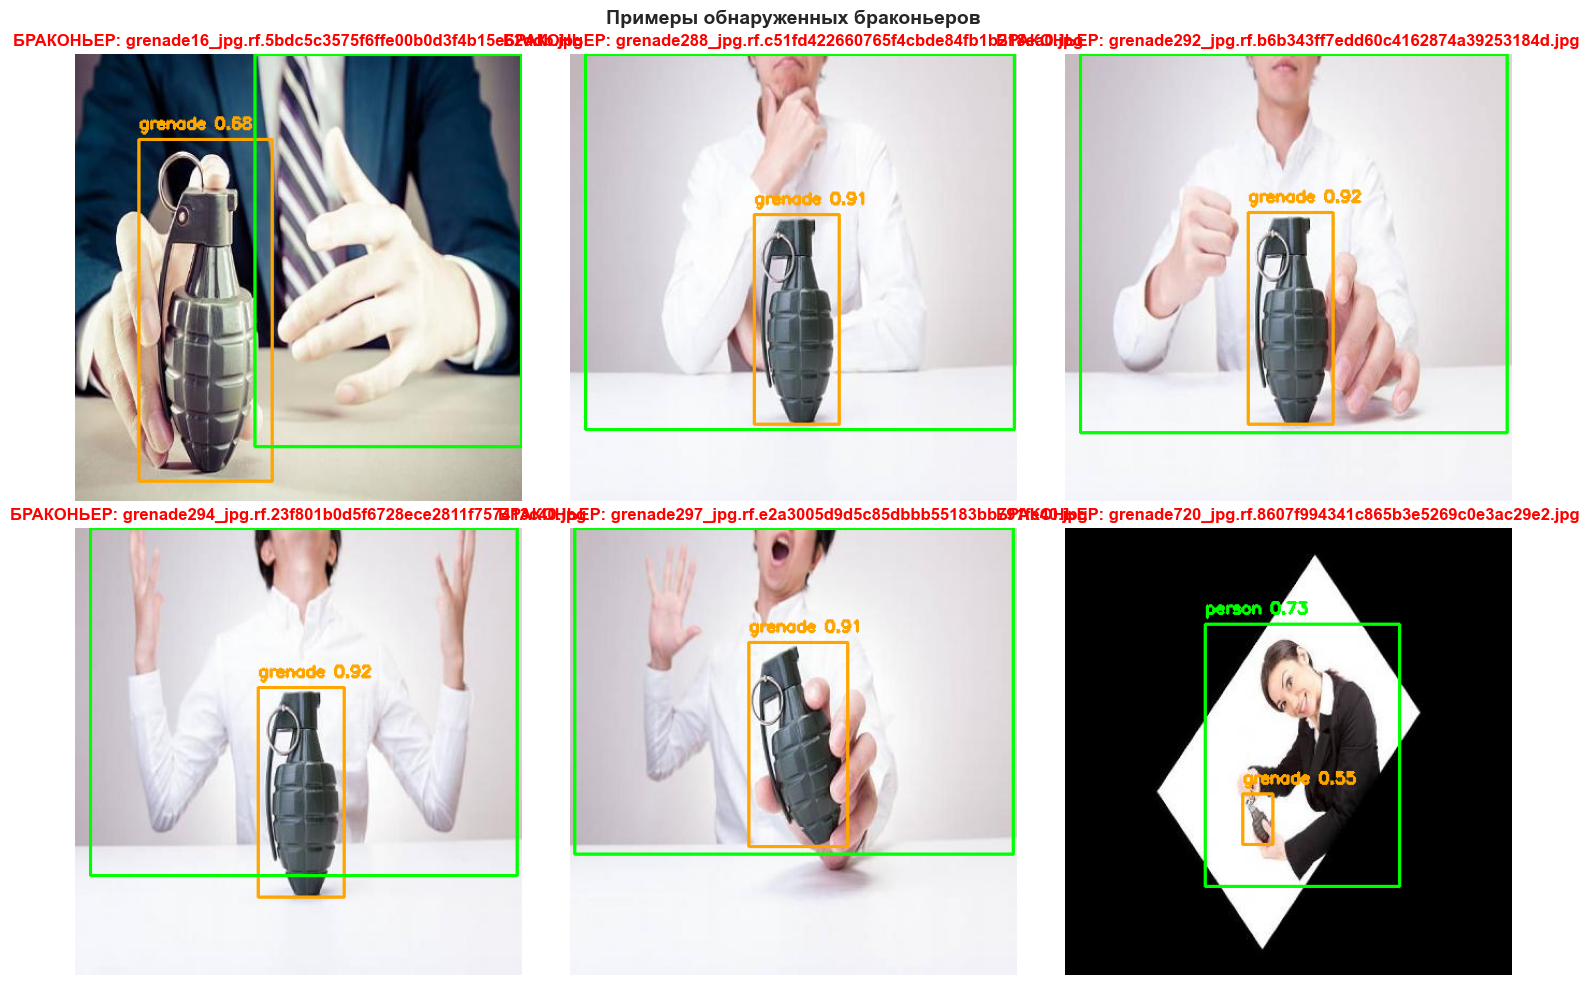

Примеры браконьеров визуализированы



In [12]:

print("\n" + "=" * 70)
print("ПРИМЕРЫ ДЕТЕКЦИЙ БРАКОНЬЕРОВ")
print("=" * 70 + "\n")

def draw_detections(image_path, result, class_names, weapon_classes, person_class):
    """
    Нарисовать детекции на изображении с цветовой кодировкой.
    """
    image = cv2.imread(str(image_path))
    if image is None:
        return None

    colors = {
        0: (0, 165, 255),  # grenade - оранжевый
        1: (0, 255, 255),  # knife - жёлтый
        2: (0, 0, 255),    # pistol - красный
        3: (255, 0, 0),    # rifle - синий
        4: (0, 255, 0)     # person - зелёный
    }

    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls)
        confidence = float(box.conf)

        color = colors.get(class_id, (255, 255, 255))

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = f"{class_names[class_id]} {confidence:.2f}"
        cv2.putText(image, label, (x1, y1 - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Показать примеры браконьеров
n_poachers = min(6, len(poacher_detections))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(n_poachers):
    img_path, result = poacher_detections[idx]
    annotated_img = draw_detections(img_path, result, CLASS_NAMES, WEAPON_CLASSES, PERSON_CLASS)

    if annotated_img is not None:
        axes[idx].imshow(annotated_img)
        axes[idx].set_title(f'БРАКОНЬЕР: {img_path.name}', fontweight='bold', color='red')
        axes[idx].axis('off')

plt.suptitle('Примеры обнаруженных браконьеров', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Примеры браконьеров визуализированы\n")


# ЧАСТЬ 5: РАСПРЕДЕЛЕНИЕ ТИПОВ ОРУЖИЯ СРЕДИ БРАКОНЬЕРОВ

АНАЛИЗ ТИПОВ ОРУЖИЯ У БРАКОНЬЕРОВ



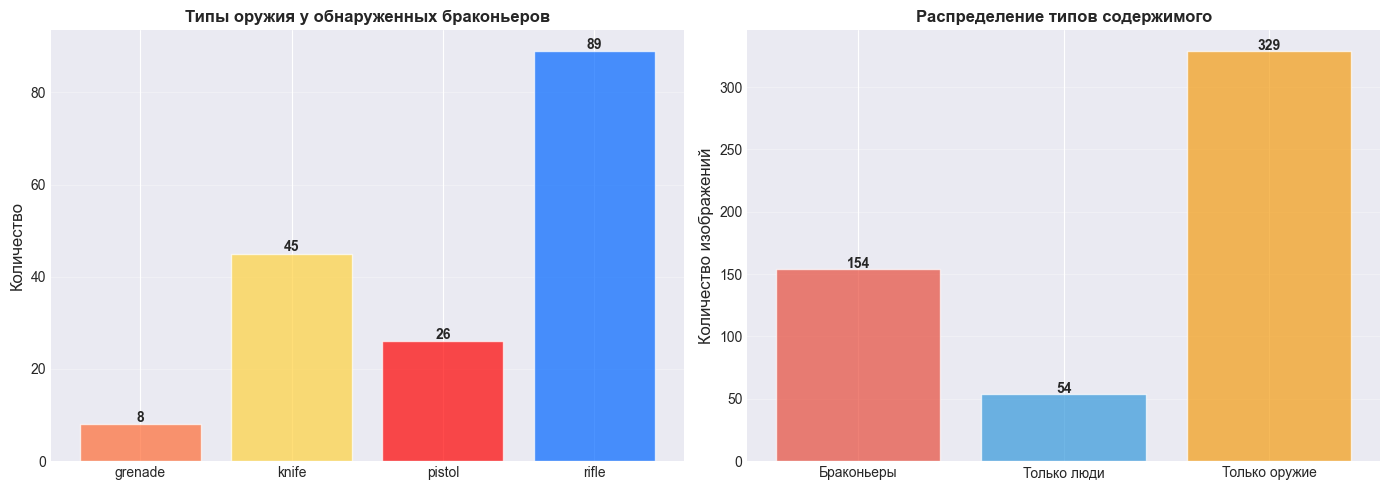

Анализ завершён



In [14]:
print("=" * 70)
print("АНАЛИЗ ТИПОВ ОРУЖИЯ У БРАКОНЬЕРОВ")
print("=" * 70 + "\n")

weapon_types = {'grenade': 0, 'knife': 0, 'pistol': 0, 'rifle': 0}

for img_path, result in poacher_detections:
    for box in result.boxes:
        class_id = int(box.cls)
        if class_id in WEAPON_CLASSES:
            weapon_name = CLASS_NAMES[class_id]
            weapon_types[weapon_name] += 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Типы оружия у браконьеров
axes[0].bar(weapon_types.keys(), weapon_types.values(),
            color=['#FF6B35', '#FFD23F', '#FF0000', '#0066FF'], alpha=0.7)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_title('Типы оружия у обнаруженных браконьеров', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, (k, v) in enumerate(weapon_types.items()):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# График 2: Распределение тип контента
types_count = [poacher_count, person_only_count, weapon_only_count]
types_labels = ['Браконьеры', 'Только люди', 'Только оружие']
colors = ['#e74c3c', '#3498db', '#f39c12']

axes[1].bar(types_labels, types_count, color=colors, alpha=0.7)
axes[1].set_ylabel('Количество изображений', fontsize=12)
axes[1].set_title('Распределение типов содержимого', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(types_count):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Анализ завершён\n")


# ЧАСТЬ 6: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ


In [15]:
print("=" * 70)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 70 + "\n")

results_json = {
    "evaluation_results": {
        "total_test_images": total_images,
        "poachers_detected": poacher_count,
        "person_only": person_only_count,
        "weapon_only": weapon_only_count,
        "detection_rate": f"{poacher_count/total_images*100:.1f}%"
    },
    "weapon_statistics": weapon_types,
    "class_detections": weapon_stats,
    "model": str(MODEL_PATH),
    "timestamp": str(pd.Timestamp.now())
}

results_path = RESULTS_DIR / 'poacher_detection_results.json'
with open(results_path, 'w') as f:
    json.dump(results_json, f, indent=2, ensure_ascii=False)

print(f"Результаты сохранены: {results_path}\n")


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

Результаты сохранены: ..\results\poacher_detection_results.json



# ЧАСТЬ 7: ФУНКЦИЯ ДЛЯ ИСПОЛЬЗОВАНИЯ В PRODUCTION


In [17]:
print("=" * 70)
print("ФУНКЦИЯ ОПРЕДЕЛЕНИЯ БРАКОНЬЕРОВ")
print("=" * 70 + "\n")

def detect_and_classify_poachers(image_path, model, class_names,
                                  weapon_classes={0,1,2,3}, person_class=4,
                                  conf_threshold=0.5):
    """
    Обнаружить и классифицировать браконьеров на изображении.

    Args:
        image_path: путь к изображению
        model: обученная модель YOLOv8
        class_names: словарь названий классов
        weapon_classes: набор ID классов оружия
        person_class: ID класса человека
        conf_threshold: порог уверенности

    Returns:
        {
            'is_poacher': bool,
            'detections': [{'class': str, 'confidence': float, 'bbox': list}],
            'weapons_found': list,
            'alert_level': str  # 'SAFE', 'PERSON', 'WEAPON', 'POACHER_ALERT'
        }
    """
    results = model.predict(str(image_path), conf=conf_threshold, verbose=False)

    detections = []
    weapons_found = []
    classes_in_image = set()

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            classes_in_image.add(class_id)

            detection = {
                'class': class_names[class_id],
                'confidence': float(box.conf),
                'bbox': [int(x) for x in box.xyxy[0].tolist()],
            }
            detections.append(detection)

            if class_id in weapon_classes:
                weapons_found.append(class_names[class_id])

    # Определить уровень угрозы
    has_person = person_class in classes_in_image
    has_weapon = any(w in classes_in_image for w in weapon_classes)

    if has_person and has_weapon:
        alert_level = 'POACHER_ALERT'
        is_poacher = True
    elif has_person:
        alert_level = 'PERSON'
        is_poacher = False
    elif has_weapon:
        alert_level = 'WEAPON'
        is_poacher = False
    else:
        alert_level = 'SAFE'
        is_poacher = False

    return {
        'is_poacher': is_poacher,
        'detections': detections,
        'weapons_found': list(set(weapons_found)),
        'alert_level': alert_level
    }

print("Функция detect_and_classify_poachers() готова к использованию!\n")

print("Пример использования:")
print("""
# Анализировать одно изображение
result = detect_and_classify_poachers(
    'path/to/image.jpg',
    model,
    CLASS_NAMES,
    weapon_classes={0,1,2,3},
    person_class=4
)

if result['is_poacher']:
    print(f"ВНИМАНИЕ: Браконьер обнаружен!")
    print(f"Типы оружия: {result['weapons_found']}")
else:
    print(f"Уровень угрозы: {result['alert_level']}")

# Батч-обработка директории
from pathlib import Path

for img_file in Path('images/').glob('*.jpg'):
    result = detect_and_classify_poachers(str(img_file), model, CLASS_NAMES)
    if result['is_poacher']:
        print(f"{img_file.name} - БРАКОНЬЕР!")
""")

ФУНКЦИЯ ОПРЕДЕЛЕНИЯ БРАКОНЬЕРОВ

Функция detect_and_classify_poachers() готова к использованию!

Пример использования:

# Анализировать одно изображение
result = detect_and_classify_poachers(
    'path/to/image.jpg',
    model,
    CLASS_NAMES,
    weapon_classes={0,1,2,3},
    person_class=4
)

if result['is_poacher']:
    print(f"ВНИМАНИЕ: Браконьер обнаружен!")
    print(f"Типы оружия: {result['weapons_found']}")
else:
    print(f"Уровень угрозы: {result['alert_level']}")

# Батч-обработка директории
from pathlib import Path

for img_file in Path('images/').glob('*.jpg'):
    result = detect_and_classify_poachers(str(img_file), model, CLASS_NAMES)
    if result['is_poacher']:
        print(f"{img_file.name} - БРАКОНЬЕР!")



# ЧАСТЬ 8: ИТОГОВЫЙ ОТЧЁТ


In [18]:

print("\n" + "=" * 70)
print("ИТОГОВЫЙ ОТЧЁТ")
print("=" * 70 + "\n")

print("✅ Модель успешно обучена и оценена!\n")

print(f"Итоги:")
print(f"   Модель: YOLOv8 Nano (person-weapon-v2)")
print(f"   Классы: {list(CLASS_NAMES.values())}")
print(f"   Test изображений: {total_images}")
print(f"   Браконьеры обнаружены: {poacher_count}")
print(f"   Точность обнаружения: {poacher_count/total_images*100:.1f}%")

print(f"\nФайлы:")
print(f"   Модель: {MODEL_PATH}")
print(f"   Результаты: {results_path}")

print(f"\nЛогика определения браконьера:")
print(f"   IF (Person обнаружен) AND (Оружие обнаружено)")
print(f"   THEN -> БРАКОНЬЕР (Alert Level: POACHER_ALERT)")

print(f"\nДЕМОНСТРАЦИЯ ЗАВЕРШЕНА!\n")

print("Модель готова к использованию в production!")



ИТОГОВЫЙ ОТЧЁТ

✅ Модель успешно обучена и оценена!

Итоги:
   Модель: YOLOv8 Nano (person-weapon-v2)
   Классы: ['grenade', 'knife', 'pistol', 'rifle', 'person']
   Test изображений: 565
   Браконьеры обнаружены: 154
   Точность обнаружения: 27.3%

Файлы:
   Модель: ..\models\yolov8n_best.pt
   Результаты: ..\results\poacher_detection_results.json

Логика определения браконьера:
   IF (Person обнаружен) AND (Оружие обнаружено)
   THEN -> БРАКОНЬЕР (Alert Level: POACHER_ALERT)

ДЕМОНСТРАЦИЯ ЗАВЕРШЕНА!

Модель готова к использованию в production!


In [19]:
# Анализировать одно изображение
result = detect_and_classify_poachers(
    'images.jpeg',
    model,
    CLASS_NAMES,
    weapon_classes={0,1,2,3},
    person_class=4
)
print(result)

{'is_poacher': True, 'detections': [{'class': 'person', 'confidence': 0.7381432056427002, 'bbox': [9, 7, 123, 255]}, {'class': 'rifle', 'confidence': 0.5885264873504639, 'bbox': [88, 19, 189, 183]}], 'weapons_found': ['rifle'], 'alert_level': 'POACHER_ALERT'}
